In [107]:
#upload some useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import statistics
warnings.filterwarnings('ignore')
%matplotlib inline

# **INITIAL ANALYSIS**

In [108]:
#loading data
df_train = pd.read_csv('train.csv',index_col=0)

Explanation of variables in df_train:

*price*: final house price (i.e., the target variable) 

*balcony*: flag specifying the presence of a balcony 

*condition*: current conditions of the house 

*construction_year*: year in which the house was built 

*latitude*: latitude of the house position

*longitude*: longitude of the house position

*energy_efficiency*: energy efficiency score

*expenses*: maintenance charges (i.e., in Italian "spese condominiali")

*floor*: floor at which the house is located

*garden*: flag specifying the presence of a garden

*n_bathrooms*: number of bathrooms

*elevator*: whether an elevator is available or not

*total_floors*: total number of floors of the building

*n_rooms*: number of rooms in the house

*proximity_center*: measure of the distance between the house and the city center (=1 if the house is within the city center, if <1 the house is outside the city center)

*surface*: surface of the house

In [109]:
#check columns
df_train.columns

Index(['price', 'balcony', 'conditions', 'construction_year', 'latitude',
       'longitude', 'energy_efficiency', 'expenses', 'floor', 'garden',
       'n_bathrooms', 'elevator', 'total_floors', 'n_rooms',
       'proximity_to_center', 'surface'],
      dtype='object')

In [110]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46312 entries, 10461 to 27322
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                46312 non-null  int64  
 1   balcony              30869 non-null  object 
 2   conditions           45083 non-null  object 
 3   construction_year    32366 non-null  float64
 4   latitude             46299 non-null  float64
 5   longitude            46299 non-null  float64
 6   energy_efficiency    26409 non-null  float64
 7   expenses             30158 non-null  float64
 8   floor                44281 non-null  float64
 9   garden               14783 non-null  object 
 10  n_bathrooms          43896 non-null  float64
 11  elevator             28869 non-null  float64
 12  total_floors         27963 non-null  float64
 13  n_rooms              45959 non-null  float64
 14  proximity_to_center  46299 non-null  float64
 15  surface              45869 non-n

In [111]:
df_train['price'].describe()

count    4.631200e+04
mean     5.031879e+05
std      1.106504e+06
min      1.540000e+02
25%      1.990000e+05
50%      3.150000e+05
75%      5.150000e+05
max      7.200000e+07
Name: price, dtype: float64

Skewness: 24.733627
Kurtosis: 1012.453475


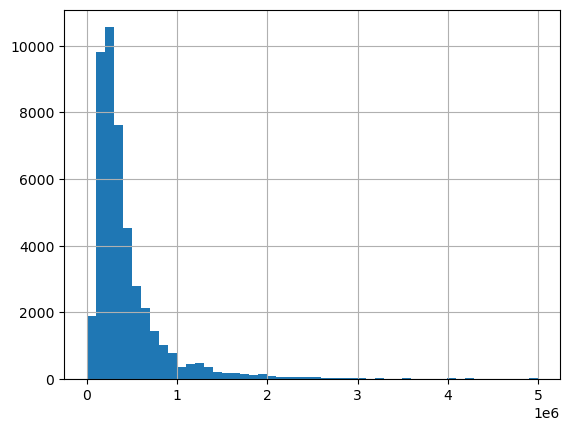

In [112]:
#skewness and kurtosis
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())
df_train[df_train.price < 0.5*10e6]['price'].hist(bins=50)
plt.show()

Price has a lot of outliers (very high values). The solution is either to reject the outliers or use a log scale.

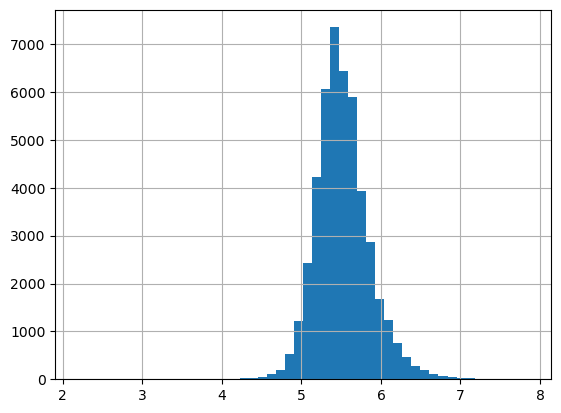

In [113]:
df_train['price_log10'] = np.log10(df_train.price.values)
df_train['price_log10'].hist(bins=50)
plt.show()

The distribution is much closer to normal. It is advised to proceed with analysis by searching for log_10 values of prices.

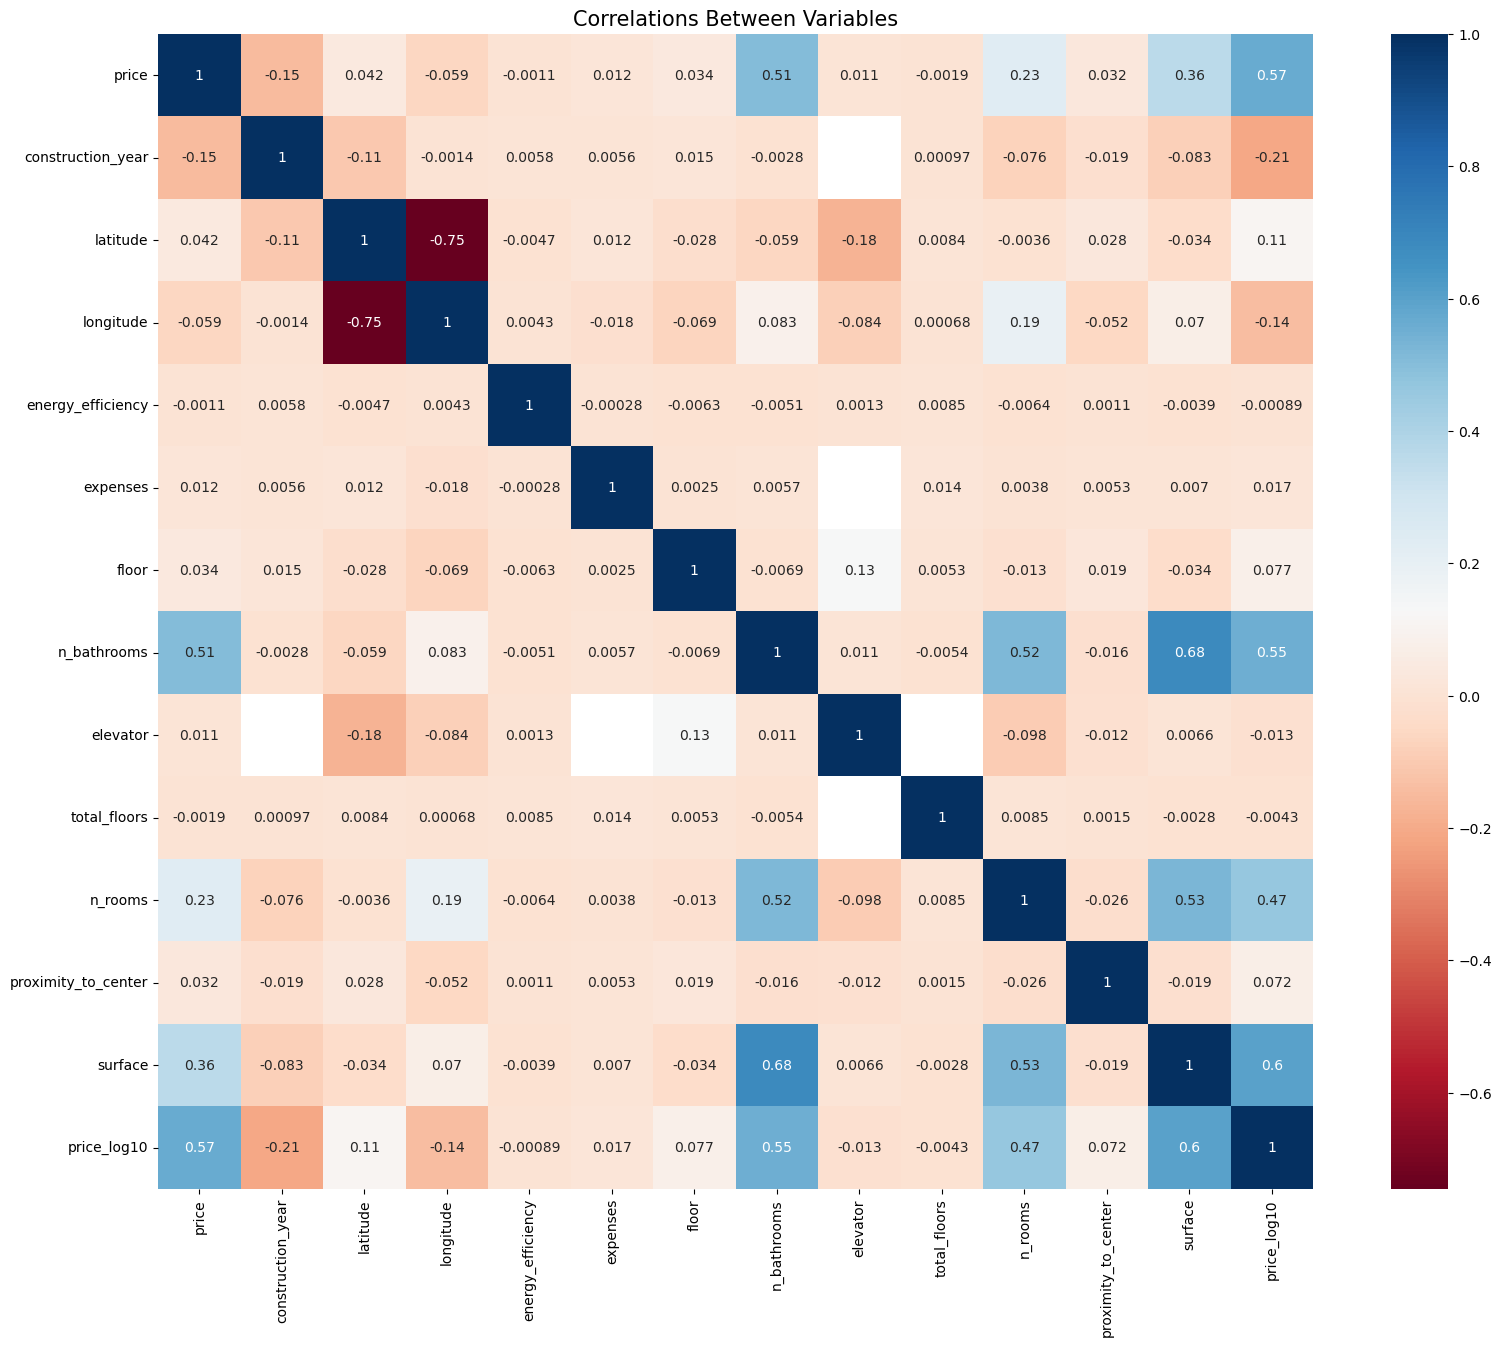

In [114]:
#initial correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
plt.title("Correlations Between Variables", size=15)
plt.show()

Also log scale proves to have better correlations with numerical features present in the dataset.

#  **DATA CLEANING**

***DUPLICATES***

In [115]:
df_train.loc[df_train.duplicated()]

,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,price_log10
id,,,,,,,,,,,,,,,,,


No duplicates present in the dataset

***OUTLIERS***

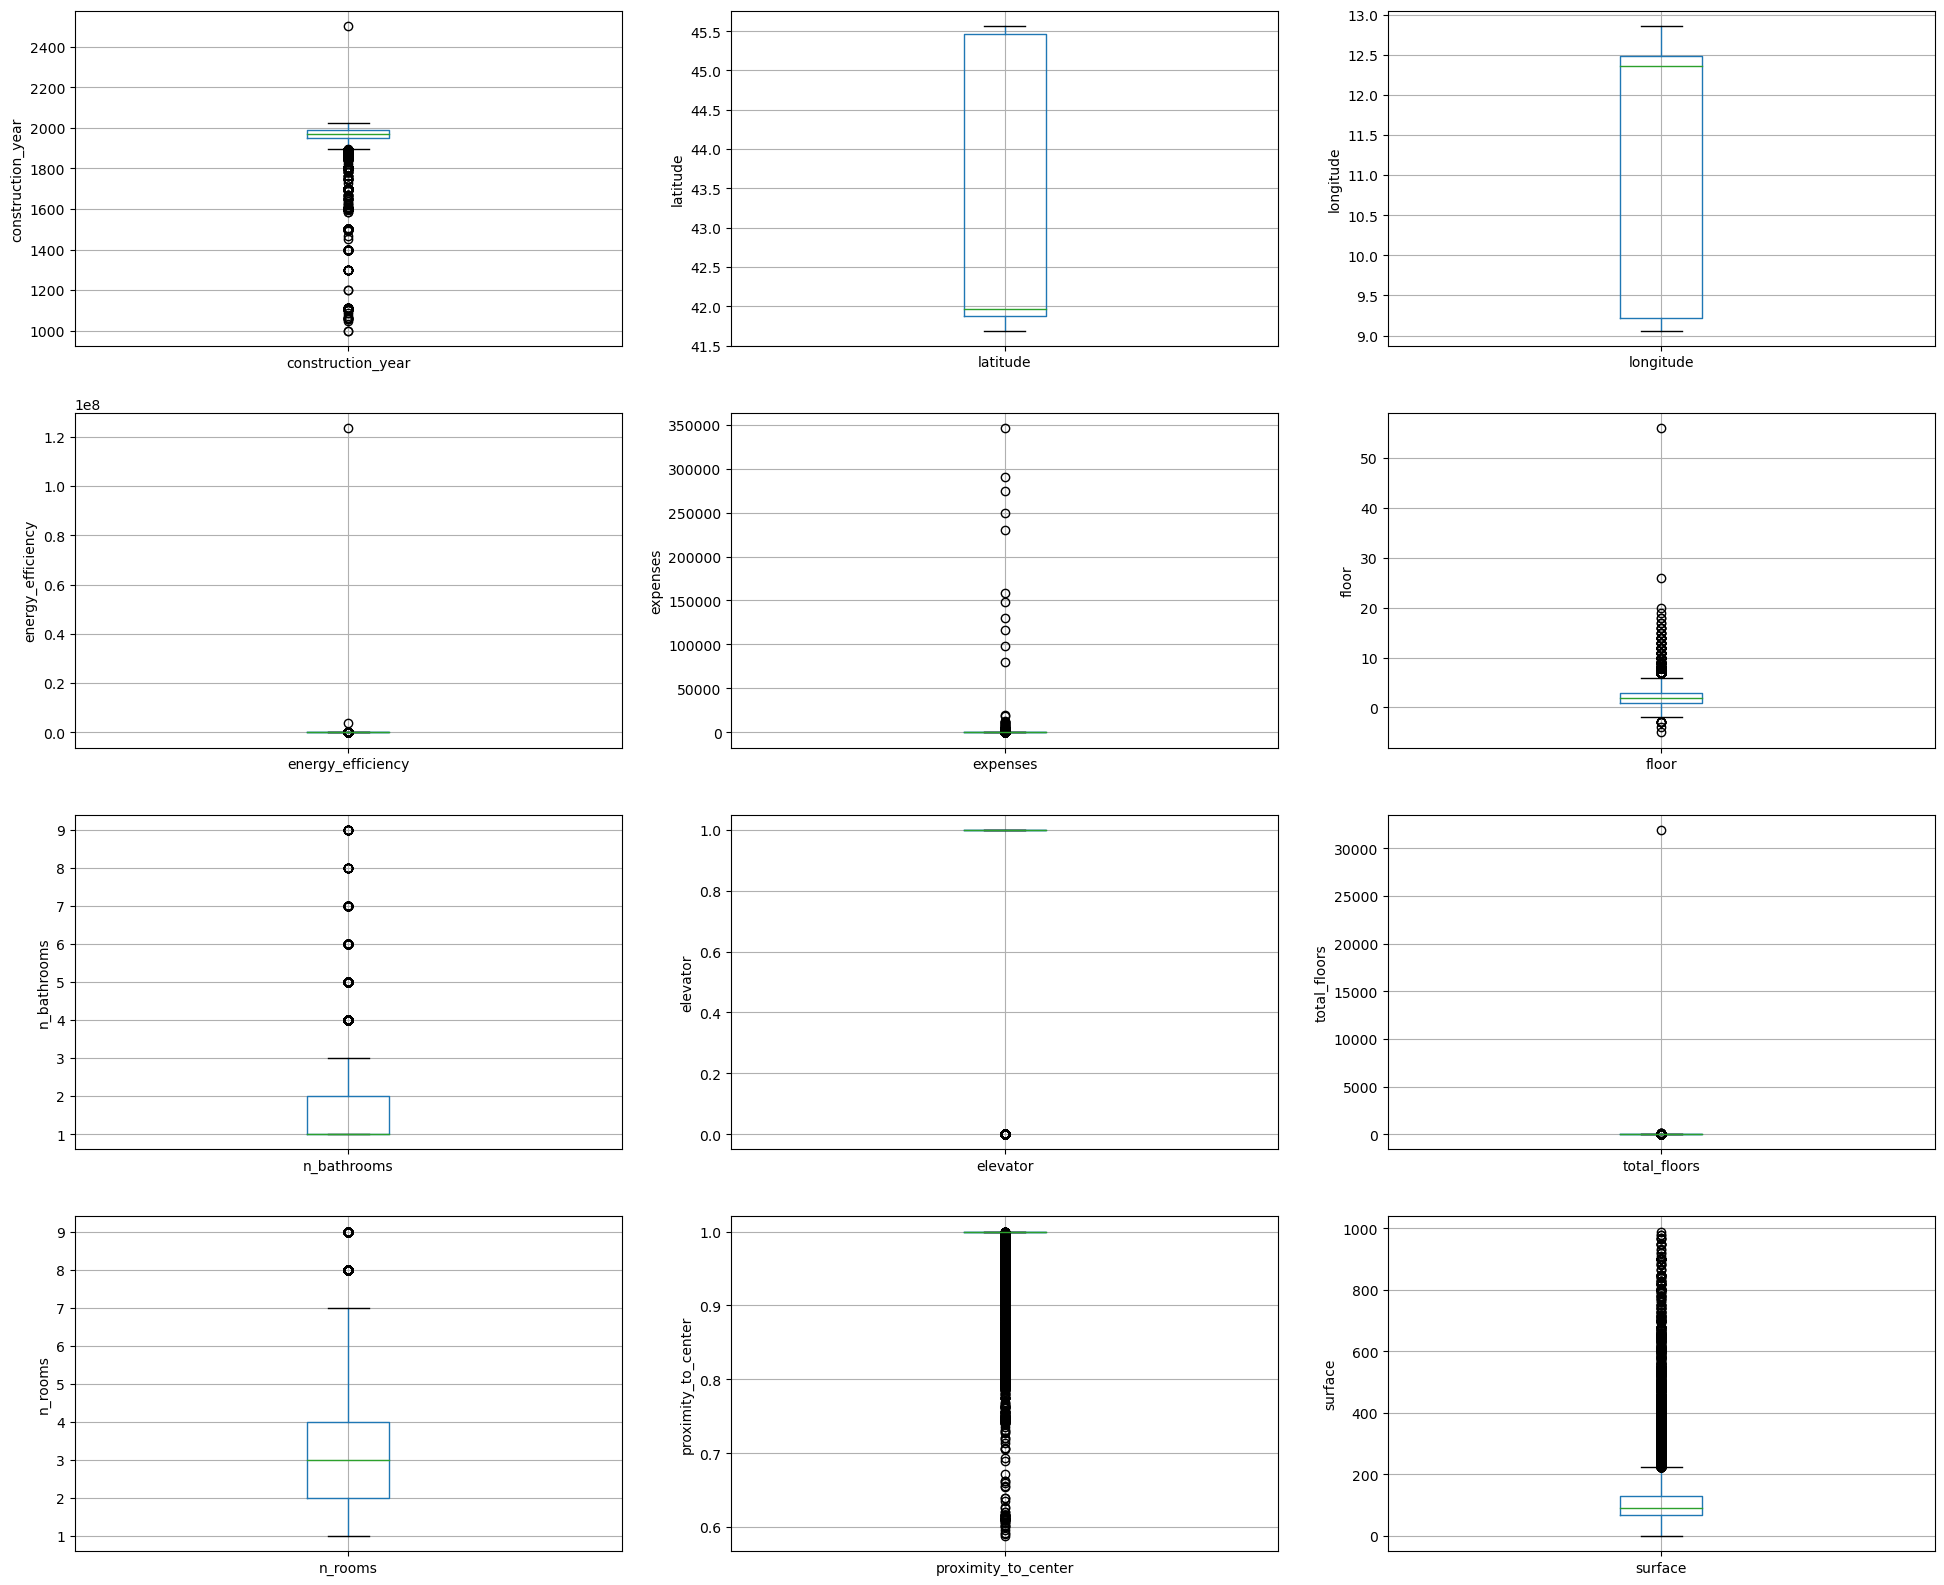

In [116]:
# draw boxplots to visualize outliers
# construction_year, latitude, longitude, energy_efficiency, expenses, floor, n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface

plt.figure(figsize=(24,20))

plt.subplot(4, 3, 1)
fig = df_train.boxplot(column='construction_year')
fig.set_title('')
fig.set_ylabel('construction_year')

plt.subplot(4, 3, 2)
fig = df_train.boxplot(column='latitude')
fig.set_title('')
fig.set_ylabel('latitude')

plt.subplot(4, 3, 3)
fig = df_train.boxplot(column='longitude')
fig.set_title('')
fig.set_ylabel('longitude')

plt.subplot(4, 3, 4)
fig = df_train.boxplot(column='energy_efficiency')
fig.set_title('')
fig.set_ylabel('energy_efficiency')

plt.subplot(4, 3, 5)
fig = df_train.boxplot(column='expenses')
fig.set_title('')
fig.set_ylabel('expenses')

plt.subplot(4, 3, 6)
fig = df_train.boxplot(column='floor')
fig.set_title('')
fig.set_ylabel('floor')

plt.subplot(4, 3, 7)
fig = df_train.boxplot(column='n_bathrooms')
fig.set_title('')
fig.set_ylabel('n_bathrooms')

plt.subplot(4, 3, 8)
fig = df_train.boxplot(column='elevator')
fig.set_title('')
fig.set_ylabel('elevator')

plt.subplot(4, 3, 9)
fig = df_train.boxplot(column='total_floors')
fig.set_title('')
fig.set_ylabel('total_floors')

plt.subplot(4, 3, 10)
fig = df_train.boxplot(column='n_rooms')
fig.set_title('')
fig.set_ylabel('n_rooms')

plt.subplot(4, 3, 11)
fig = df_train.boxplot(column='proximity_to_center')
fig.set_title('')
fig.set_ylabel('proximity_to_center')

plt.subplot(4, 3, 12)
fig = df_train.boxplot(column='surface')
fig.set_title('')
fig.set_ylabel('surface')

plt.show()

***MISSING DATA***

In [117]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
garden,31529,0.680795
energy_efficiency,19903,0.429759
total_floors,18349,0.396204
elevator,17443,0.376641
expenses,16154,0.348808
balcony,15443,0.333456
construction_year,13946,0.301131
n_bathrooms,2416,0.052168
floor,2031,0.043855
conditions,1229,0.026537


From the table we see that the dataset is characterized by a significant amount of missing values. Most notably, variables "garden';'energy_efficiency'; 'total_floors';'elevator';'expenses';'construction_year', are missing over 30% of their values. 

Therefore, I've decided to use deletion by **dropping the variables: 'energy_efficiency';'expenses';'construction_year';'total_floors'**.






In [118]:
print(df_train['n_bathrooms'].value_counts())
print(df_train['n_bathrooms'].describe())

1.0    24699
2.0    15080
3.0     3453
4.0      374
5.0      133
6.0       82
7.0       47
9.0       16
8.0       12
Name: n_bathrooms, dtype: int64
count    43896.000000
mean         1.559140
std          0.769869
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: n_bathrooms, dtype: float64


The majority of houses have 1 or 2 bathrooms with a mean at 1.57 and median at 1. Filling with median or mode could be an option. Especially that a lot of values is missing.
For n_rooms and surface I would drop the NAs. Hard to input something meaningfull without 

In [119]:
print(df_train['n_rooms'].value_counts())
print(df_train['n_rooms'].describe())

3.0    15116
2.0    11063
4.0     8237
5.0     7247
1.0     2572
6.0      894
7.0      424
8.0      278
9.0      128
Name: n_rooms, dtype: int64
count    45959.000000
mean         3.284166
std          1.329654
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: n_rooms, dtype: float64


In [120]:
# Unikalbym nazw z 2, 3, 4 itp. Utrudnia to orientacje co jest czym. W pythonie nazwy zmiennych z zasady zostawia sie jak najbardziej 'opisowe'
df_train_reduced = df_train.copy()

# Drop unrelevant features and price
df_train_reduced.drop(['energy_efficiency', 'expenses', 'construction_year', 'total_floors', 'price'], axis=1, inplace = True)
# Drop rows with na values 
df_train_reduced.dropna(subset=['surface', 'conditions', 'latitude', 'longitude', 'n_bathrooms'], inplace = True)
df_train_reduced['n_rooms'].fillna(df_train_reduced['n_rooms'].mode(), inplace=True)
df_train_reduced.fillna(0, inplace=True)
df_train_reduced[['balcony', 'garden']] = df_train_reduced[['balcony', 'garden']].astype(int)

# Add new feature
def no_elevator(row):
  if row.floor > 1 and row.elevator == 0 :
    return 1 # return row.floor
  else: 
    return 0

df_train_reduced['only_stairs'] = df_train_reduced.apply(lambda row: no_elevator(row), axis = 1)

corrmat = df_train_reduced.corr()
corrmat['price_log10'].sort_values(ascending=False)

price_log10            1.000000
surface                0.614671
n_bathrooms            0.553916
n_rooms                0.437149
elevator               0.186082
latitude               0.145308
floor                  0.082210
proximity_to_center    0.071545
balcony                0.067846
garden                 0.008636
only_stairs           -0.109960
longitude             -0.173712
Name: price_log10, dtype: float64

*Nie wiem czy bym dal dropna przy 'n_bathrooms' i 'surface', spada korelacja z cena przy fillna i moda. Dla 'n_rooms' brak zmiany miedzy dropna i fillna+moda.*

In [121]:
# One-hot encode the "conditions" column
conditions_dummies = pd.get_dummies(df_train_reduced['conditions'], prefix='conditions')
df_train_reduced = pd.concat([df_train_reduced, conditions_dummies], axis=1)

# Zbedne rzeczy dopiero na sam koniec bym wywalil, zeby nie bylo problemow z 'keyError'
# df_train2.drop('conditions', axis=1, inplace=True)

# corrmat = df_train_reduced.corr()
# f, ax = plt.subplots(figsize=(20, 15))
# sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
# plt.title("Correlations Between Variables", size=15)
# plt.show()

# Chwilowo wywalam te kolorowe duze matrixy. Ladne sa ale strasznie duze :D
corrmat = df_train_reduced.corr()
corrmat['price_log10'].sort_values(ascending=False)

price_log10                             1.000000
surface                                 0.614671
n_bathrooms                             0.553916
n_rooms                                 0.437149
elevator                                0.186082
latitude                                0.145308
floor                                   0.082210
conditions_Nuovo / Nuova costruzione    0.076577
proximity_to_center                     0.071545
balcony                                 0.067846
conditions_Ottimo / Ristrutturato       0.033660
garden                                  0.008636
conditions_Da ristrutturare            -0.006429
conditions_Buono stato / Abitabile     -0.080434
only_stairs                            -0.109960
longitude                              -0.173712
Name: price_log10, dtype: float64

# Coordinates clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


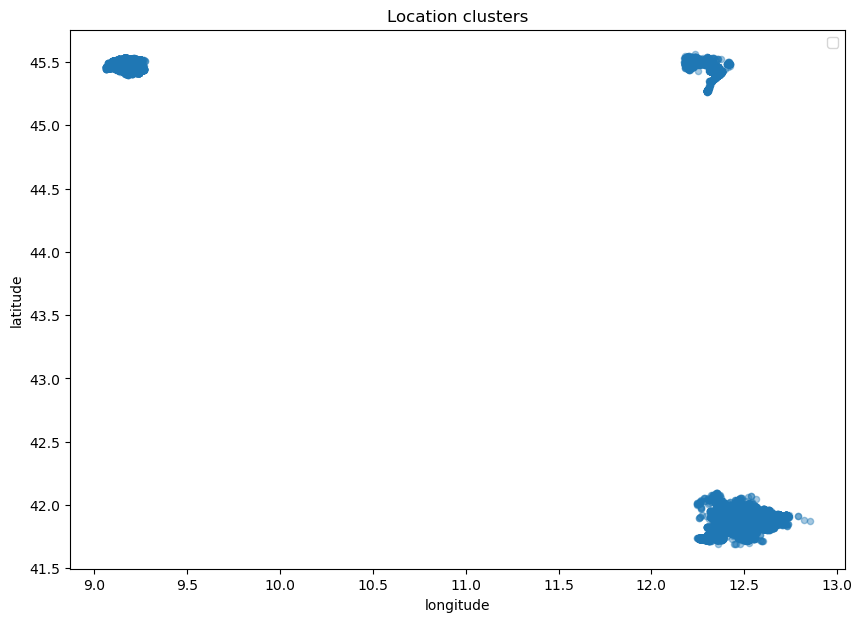

In [122]:
df_train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(10,7),title="Location clusters")
plt.legend()
plt.show()

Conclusion: There are 3 location clusters, namely Milan, Venice, and Rome.

[Annotated map](https://drive.google.com/file/d/1WgSRiyUPPy0zg5Qgcr_05SoFsI-bWHxL/view?usp=sharing)


In [48]:
### IMO niepotrzebne, juz zdecydowalismy ze dzialamy na zmienionym datasecie, wiec nie ma co wracac do oryginalnego

# df_rome = df_train[df_train["latitude"] < 42.5]
# df_milan = df_train[df_train["longitude"] < 10]
# df_venice = df_train[(df_train["latitude"] >= 42.5) & (df_train["longitude"] >= 10)]

# # Print the number of datapoints in each category
# print(f"Number of datapoints in Rome: {len(df_rome)}")
# print(f"Number of datapoints in Milan: {len(df_milan)}")
# print(f"Number of datapoints in Venice: {len(df_venice)}")

Add a 'city' variable based on the house location on the map

In [123]:
df_train_reduced.loc[df_train_reduced["latitude"] < 42.5, "city"] = "Rome"
df_train_reduced.loc[df_train_reduced["longitude"] < 10, "city"] = "Milan"
df_train_reduced.loc[(df_train_reduced["latitude"] >= 42.5) & (df_train_reduced["longitude"] >= 10), "city"] = "Venice"

# j.w.
# df_train3.drop(['latitude','longitude'], axis=1, inplace=True)

In [124]:
# j.w. dropy
df_rome = df_train_reduced[df_train_reduced["latitude"] < 42.5]
#df_rome2.drop(['latitude','longitude'], axis=1, inplace=True)
df_milan = df_train_reduced[df_train_reduced["longitude"] < 10]
#df_milan2.drop(['latitude','longitude'], axis=1, inplace=True)
df_venice = df_train_reduced[(df_train_reduced["latitude"] >= 42.5) & (df_train_reduced["longitude"] >= 10)]
#df_venice2.drop(['latitude','longitude'], axis=1, inplace=True)

# Print the number of datapoints in each category
print(f"Number of datapoints in Rome: {len(df_rome)}")
print(f"Number of datapoints in Milan: {len(df_milan)}")
print(f"Number of datapoints in Venice: {len(df_venice)}")

Number of datapoints in Rome: 22477
Number of datapoints in Milan: 13320
Number of datapoints in Venice: 6775


# Correlations for Milan

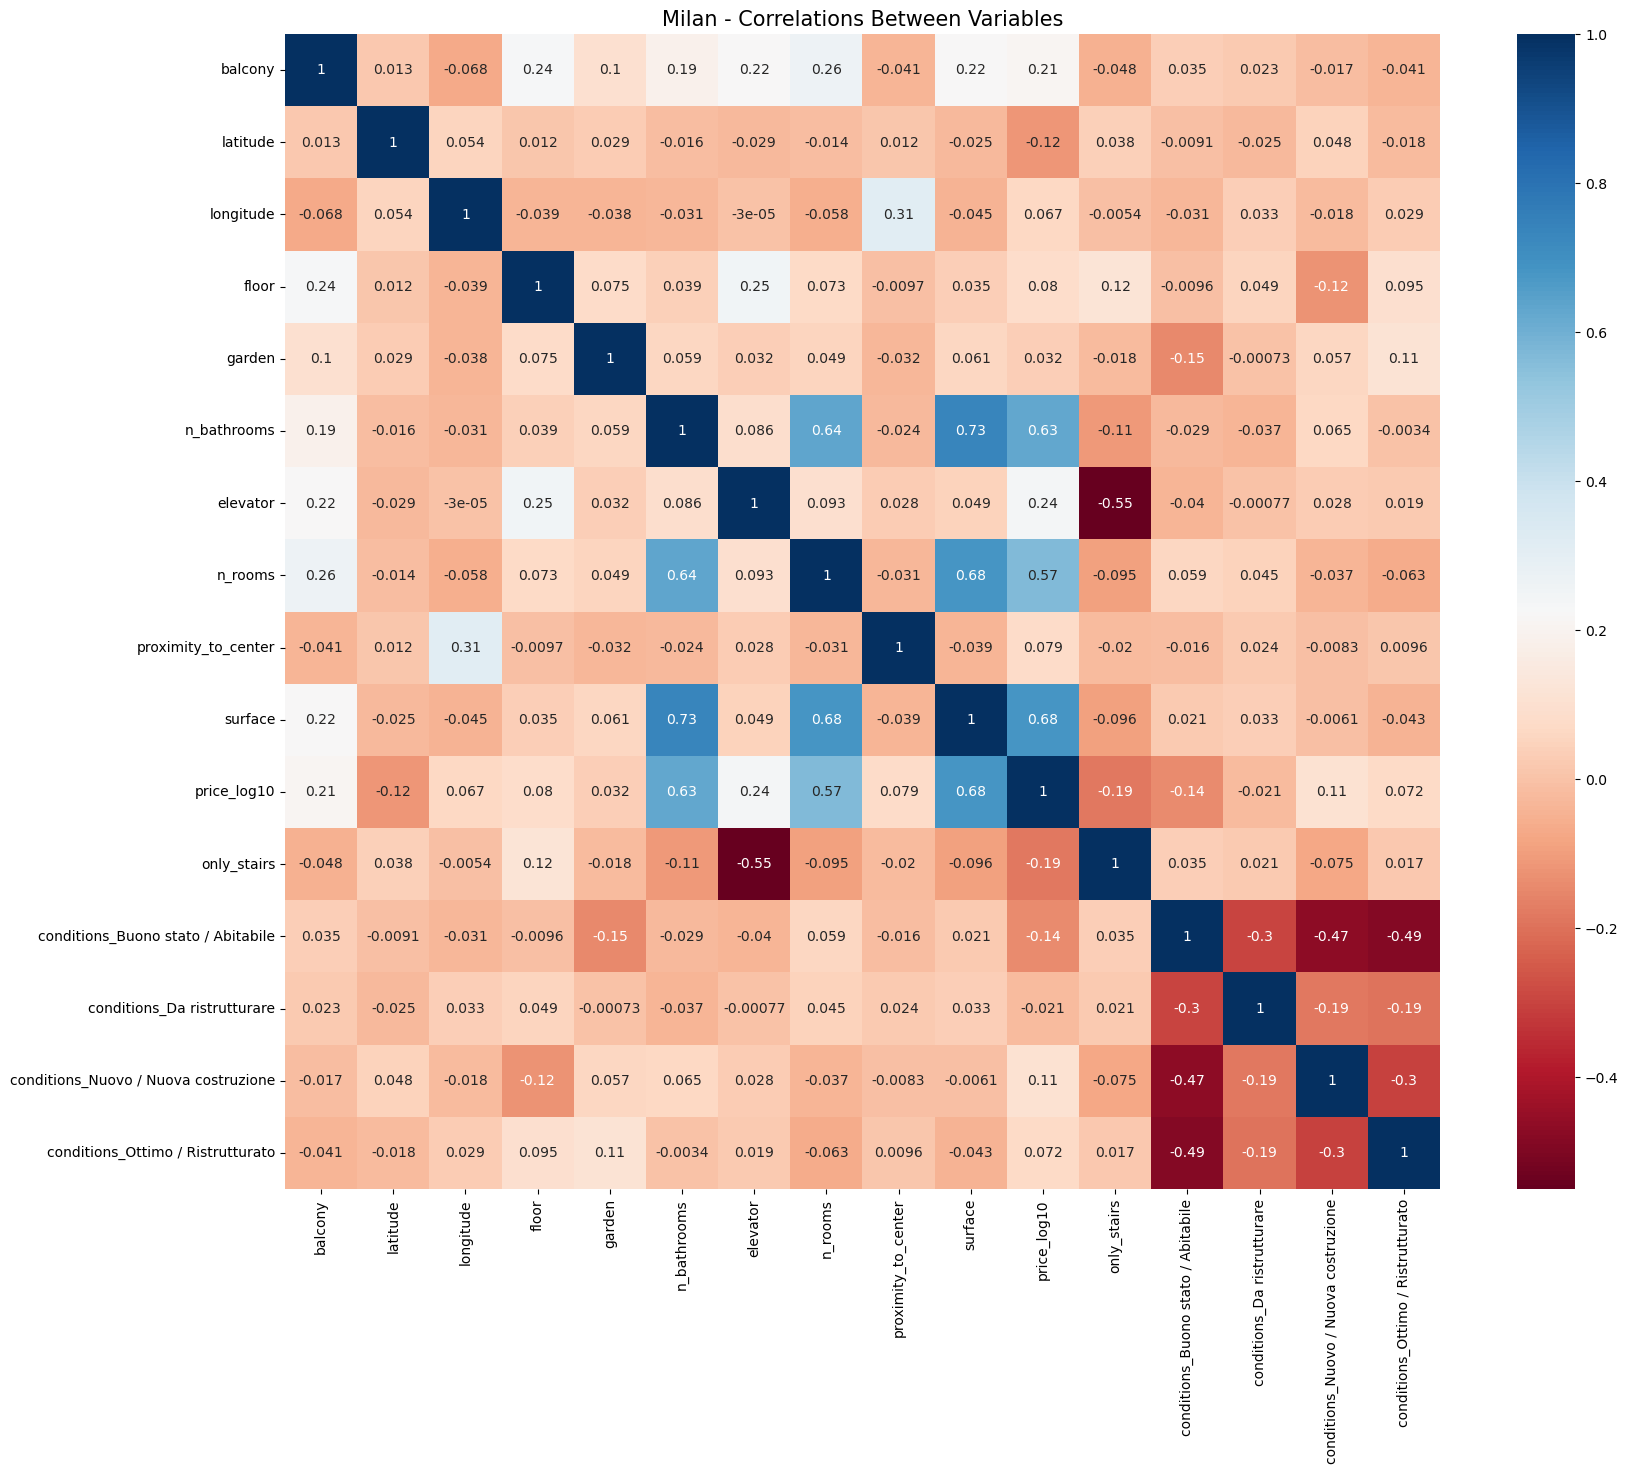

In [125]:
corrmat = df_milan.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
plt.title("Milan - Correlations Between Variables", size=15)
plt.show()

# Correlations for Rome

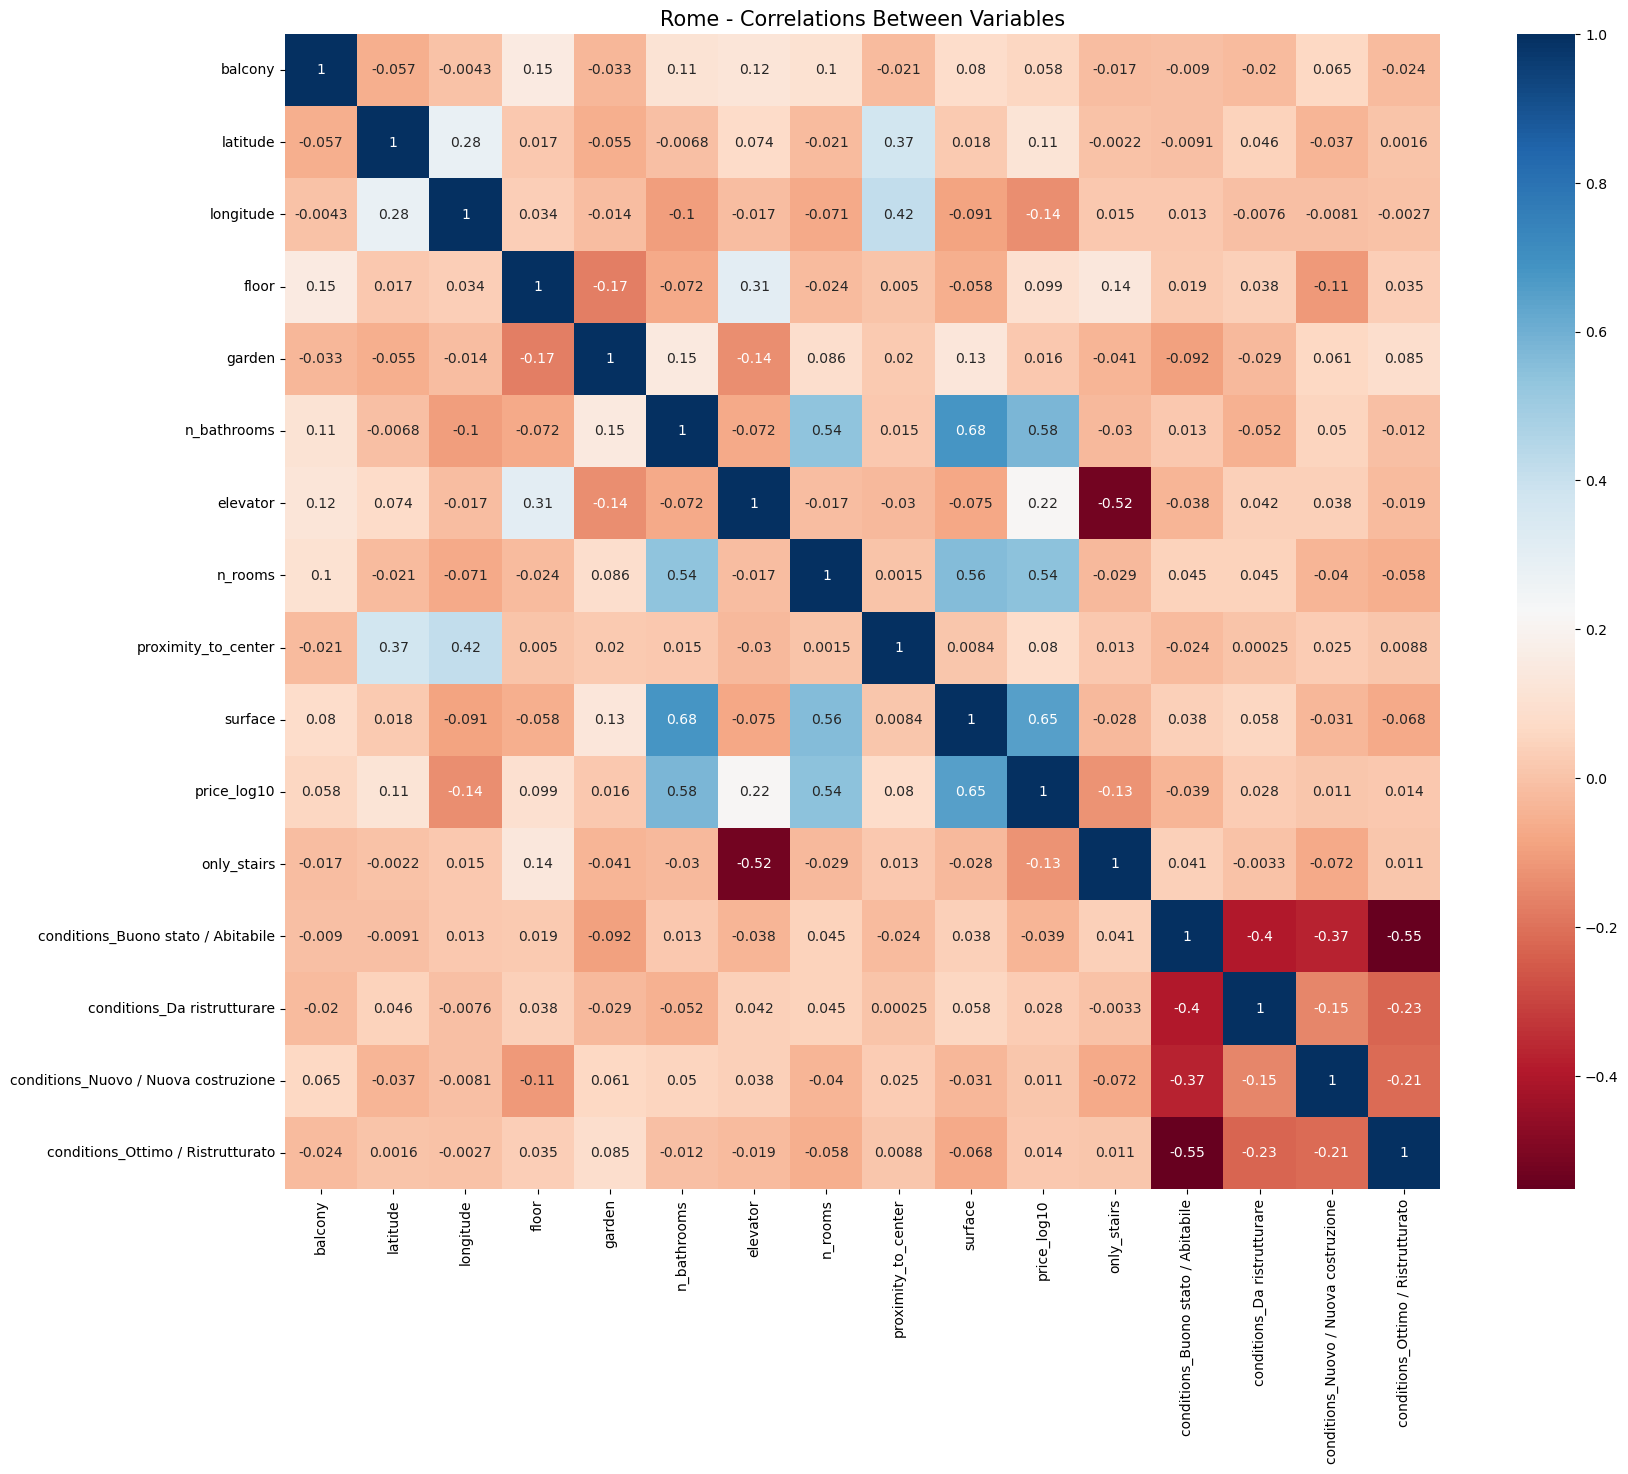

In [52]:
corrmat = df_rome.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
plt.title("Rome - Correlations Between Variables", size=15)
plt.show()

# Correlations for Venice

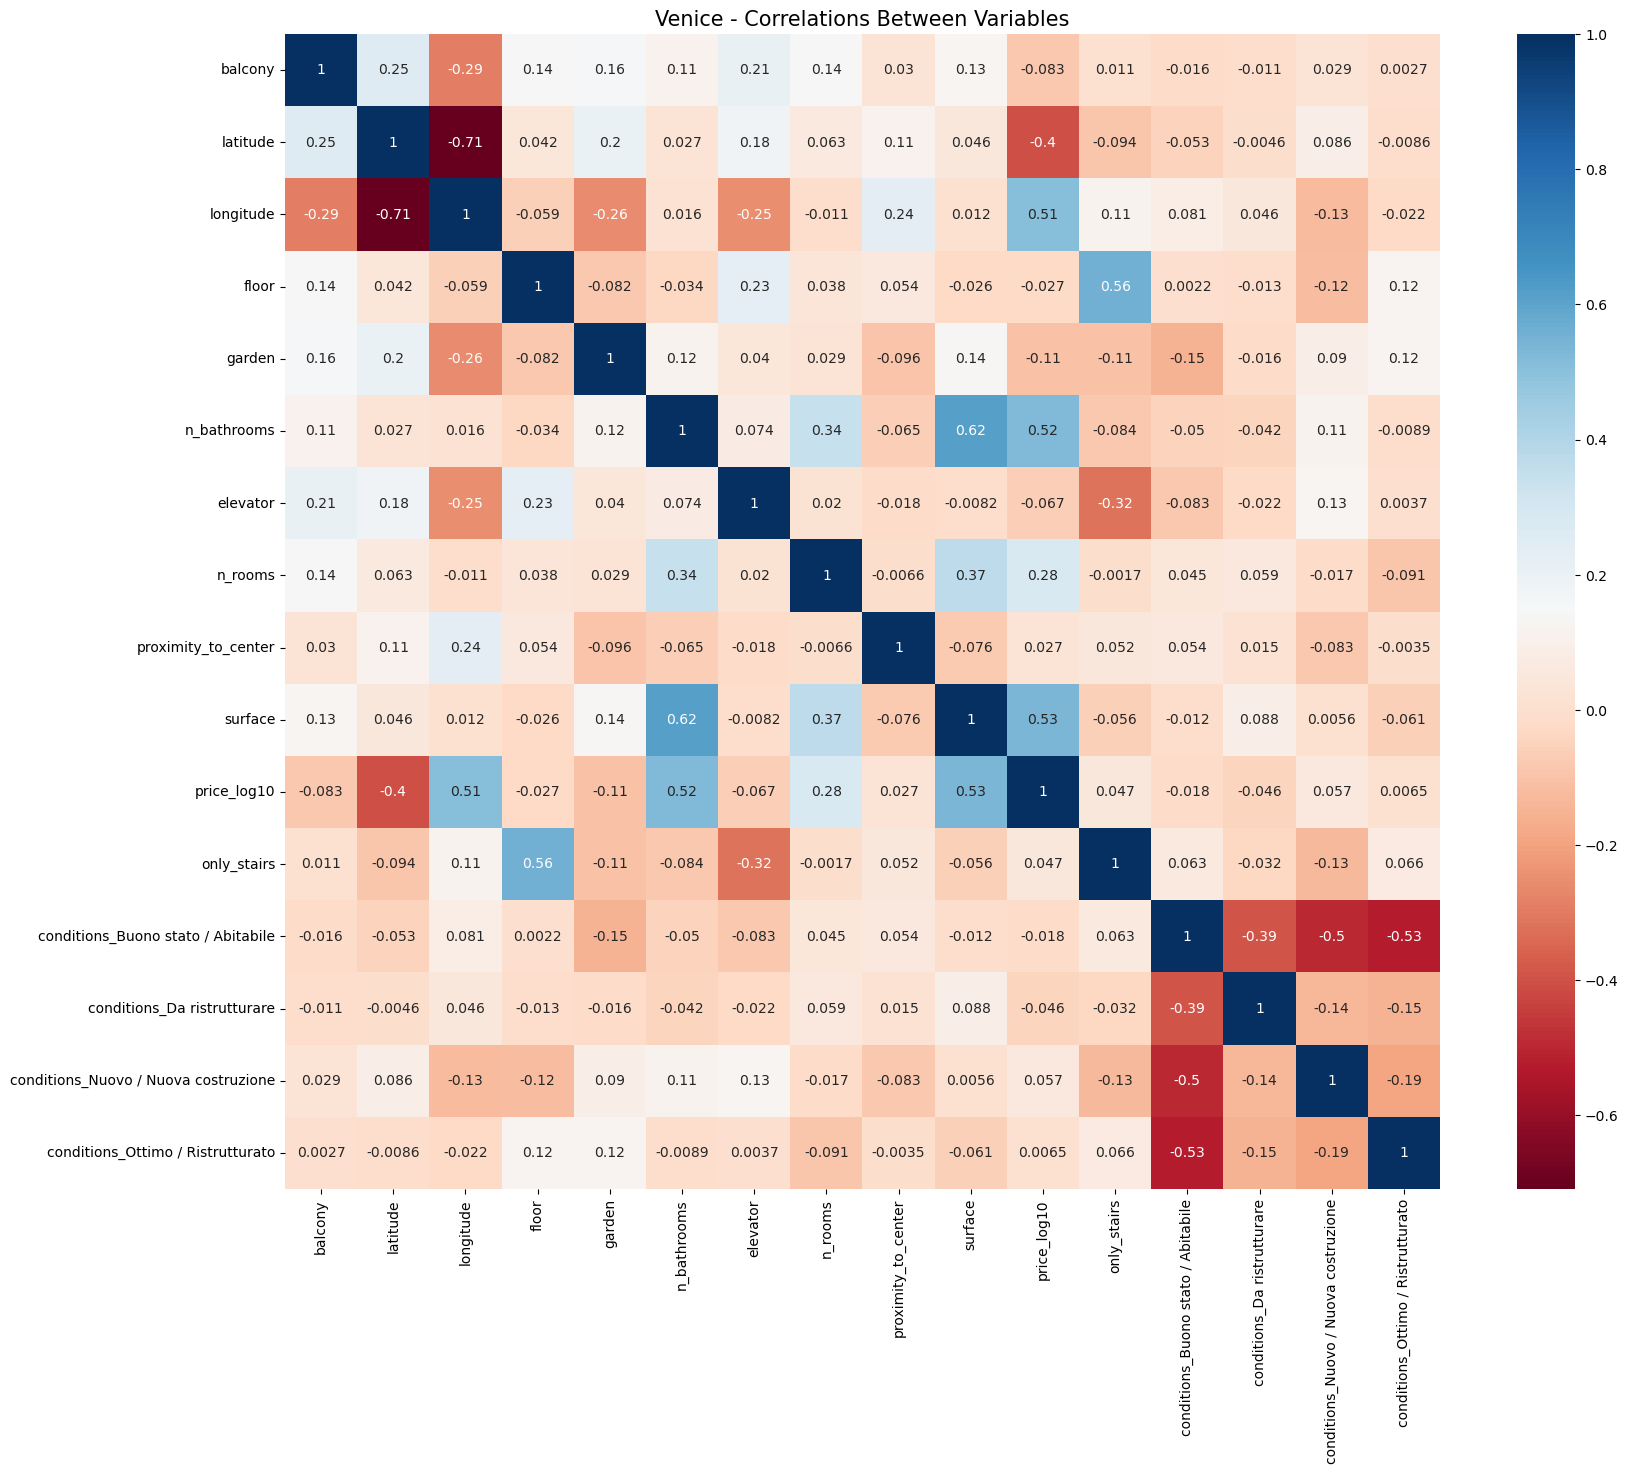

In [126]:
corrmat = df_venice.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
plt.title("Venice - Correlations Between Variables", size=15)
plt.show()

In [ ]:
# corrmat = df_train_reduced.corr()
# f, ax = plt.subplots(figsize=(20, 15))
# sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
# plt.title("City variable - Correlations Between Variables", size=15)
# plt.show()

# Conditions variable transformed into integers


In [127]:
#encode proximity
def encode(x):
 return 1 if x == 1 else 0
df_train_reduced['enc_proximity'] = df_train_reduced.proximity_to_center.apply(encode)

# j.w.
# df_train3=df_train3.drop(['proximity_to_center'],axis=1)


### To juz bylo wczesniej zrobione, nie trzeba drugi raz
# #City variable
# def which_city(row):
#   if (row.latitude > 45) & (row.longitude < 11):
#     return 'MILAN'
#   elif (row.latitude < 44):
#     return 'ROME'
#   else:
#     return 'VENICE'
# df_train3['city'] = df_train3.apply(lambda row: which_city(row), axis=1)
# city_encoded = pd.get_dummies(df_train3['city'], prefix='city')
# df_train3 = pd.concat([df_train3, city_encoded], axis=1)

# df_train3.dropna(inplace=True)

df_train_reduced.head(10)

,balcony,conditions,latitude,longitude,floor,garden,n_bathrooms,elevator,n_rooms,proximity_to_center,surface,price_log10,only_stairs,conditions_Buono stato / Abitabile,conditions_Da ristrutturare,conditions_Nuovo / Nuova costruzione,conditions_Ottimo / Ristrutturato,city,enc_proximity
id,,,,,,,,,,,,,,,,,,,
10461,1,Buono stato / Abitabile,41.901300,12.700000,2.0,0,1.0,0.0,1.0,1.00000,35.0,4.778151,1,1,0,0,0,Rome,1
51304,0,Buono stato / Abitabile,41.907017,12.481311,3.0,0,1.0,1.0,3.0,1.00000,131.0,5.954243,0,1,0,0,0,Rome,1
33032,0,Buono stato / Abitabile,41.976500,12.440500,4.0,0,1.0,0.0,1.0,1.00000,16.0,4.518514,1,1,0,0,0,Rome,1
62281,0,Ottimo / Ristrutturato,45.484800,12.198200,1.0,1,1.0,0.0,2.0,0.99205,100.0,5.220108,0,0,0,0,1,Venice,0
45681,1,Buono stato / Abitabile,45.424480,12.328622,3.0,0,2.0,1.0,3.0,1.00000,90.0,5.612784,0,1,0,0,0,Venice,1
59924,0,Buono stato / Abitabile,41.874581,12.541382,-1.0,0,1.0,0.0,2.0,1.00000,30.0,4.949390,0,1,0,0,0,Rome,1
47960,1,Buono stato / Abitabile,45.501742,12.254337,-1.0,0,1.0,1.0,5.0,1.00000,107.0,5.167317,0,1,0,0,0,Venice,1
7326,1,Ottimo / Ristrutturato,41.896900,12.519100,6.0,0,1.0,1.0,3.0,1.00000,75.0,5.439333,0,0,0,0,1,Rome,1
44039,1,Ottimo / Ristrutturato,41.906400,12.420300,0.0,1,3.0,0.0,5.0,1.00000,130.0,5.661813,0,0,0,0,1,Rome,1


In [ ]:
# Na razie do odkomentowania, ladne obrazki do raportu ale teraz zbedne imo (jak cos to ctrl+\ komentuje calosc zaznaczonego)


# df_rome = df_train3[df_train3["city"] == "ROME"]
# df_rome.drop(['city_ROME','city_MILAN','city_VENICE','latitude','longitude'], axis=1, inplace=True)
# df_milan = df_train3[df_train3["city"] == "MILAN"]
# df_milan.drop(['city_ROME','city_MILAN','city_VENICE','latitude','longitude'], axis=1, inplace=True)
# df_venice = df_train3[df_train3["city"]=="VENICE"]
# df_venice.drop(['city_ROME','city_MILAN','city_VENICE','latitude','longitude'], axis=1, inplace=True)

# corrmat = df_rome.corr()
# f, ax = plt.subplots(figsize=(6, 4))
# sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
# plt.title("Rome - Conditions as integers - Correlations Between Variables", size=10)
# plt.show()

# corrmat = df_milan.corr()
# f, ax = plt.subplots(figsize=(6, 4))
# sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
# plt.title("Milan - Conditions as integers - Correlations Between Variables", size=10)
# plt.show()

# corrmat = df_venice.corr()
# f, ax = plt.subplots(figsize=(6, 4))
# sns.heatmap(corrmat, annot=True,cmap="RdBu",square=True);
# plt.title("Venice - Conditions as integers - Correlations Between Variables", size=10)
# plt.show()

# **Bardzo dziwna sprawa: wszystkie punkty w których zaznaczono 0 elevators mają puste pola "total_floors","garden","construction_year","expenses"**

**Tak samo, wszystkie punkty z missing n_rooms mają missing n_bathrooms **

Ale martwi mnie conditions bo jednak myślę, że to powinno mieć jakieś znaczenie, i ta kwestia proximity to center lub jakiegoś innego wyznacznika lokalizacji.



*  Delete "elevator"
*   List item



# Feature engineering


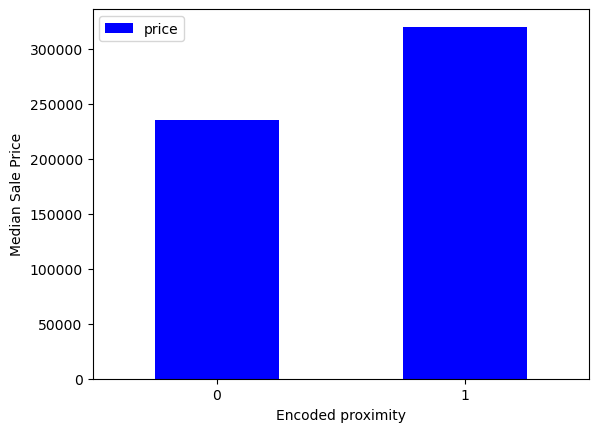

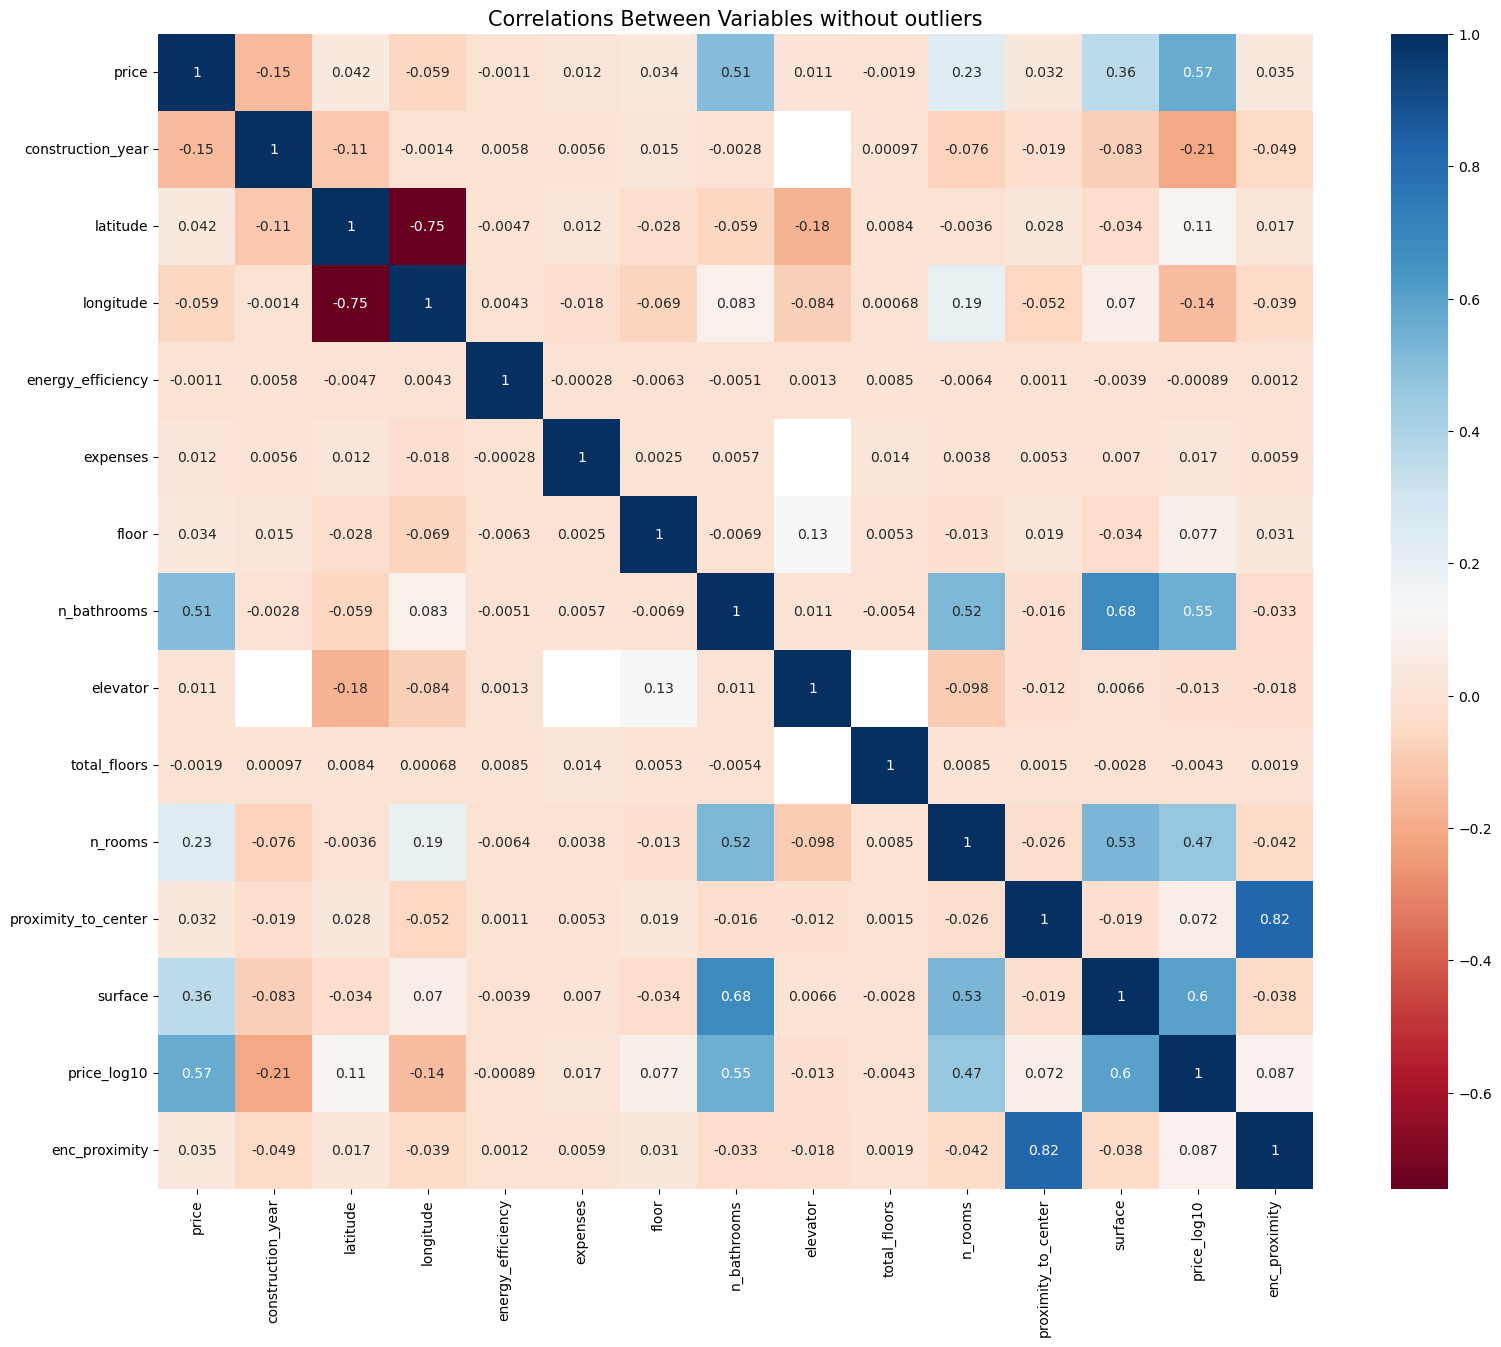

In [128]:
#Transform variable proximity_to_center by encoding it as a new categorical feature

# Juz zadeklarowane
# def encode(x):
#  return 1 if x == 1 else 0

df_train['enc_proximity'] = df_train.proximity_to_center.apply(encode)
enc_proximity_pivot = df_train.pivot_table(index='enc_proximity', values='price', aggfunc=np.median)
enc_proximity_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded proximity')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True, cmap="RdBu",square=True);
plt.title("Correlations Between Variables without outliers", size=15)
plt.show()

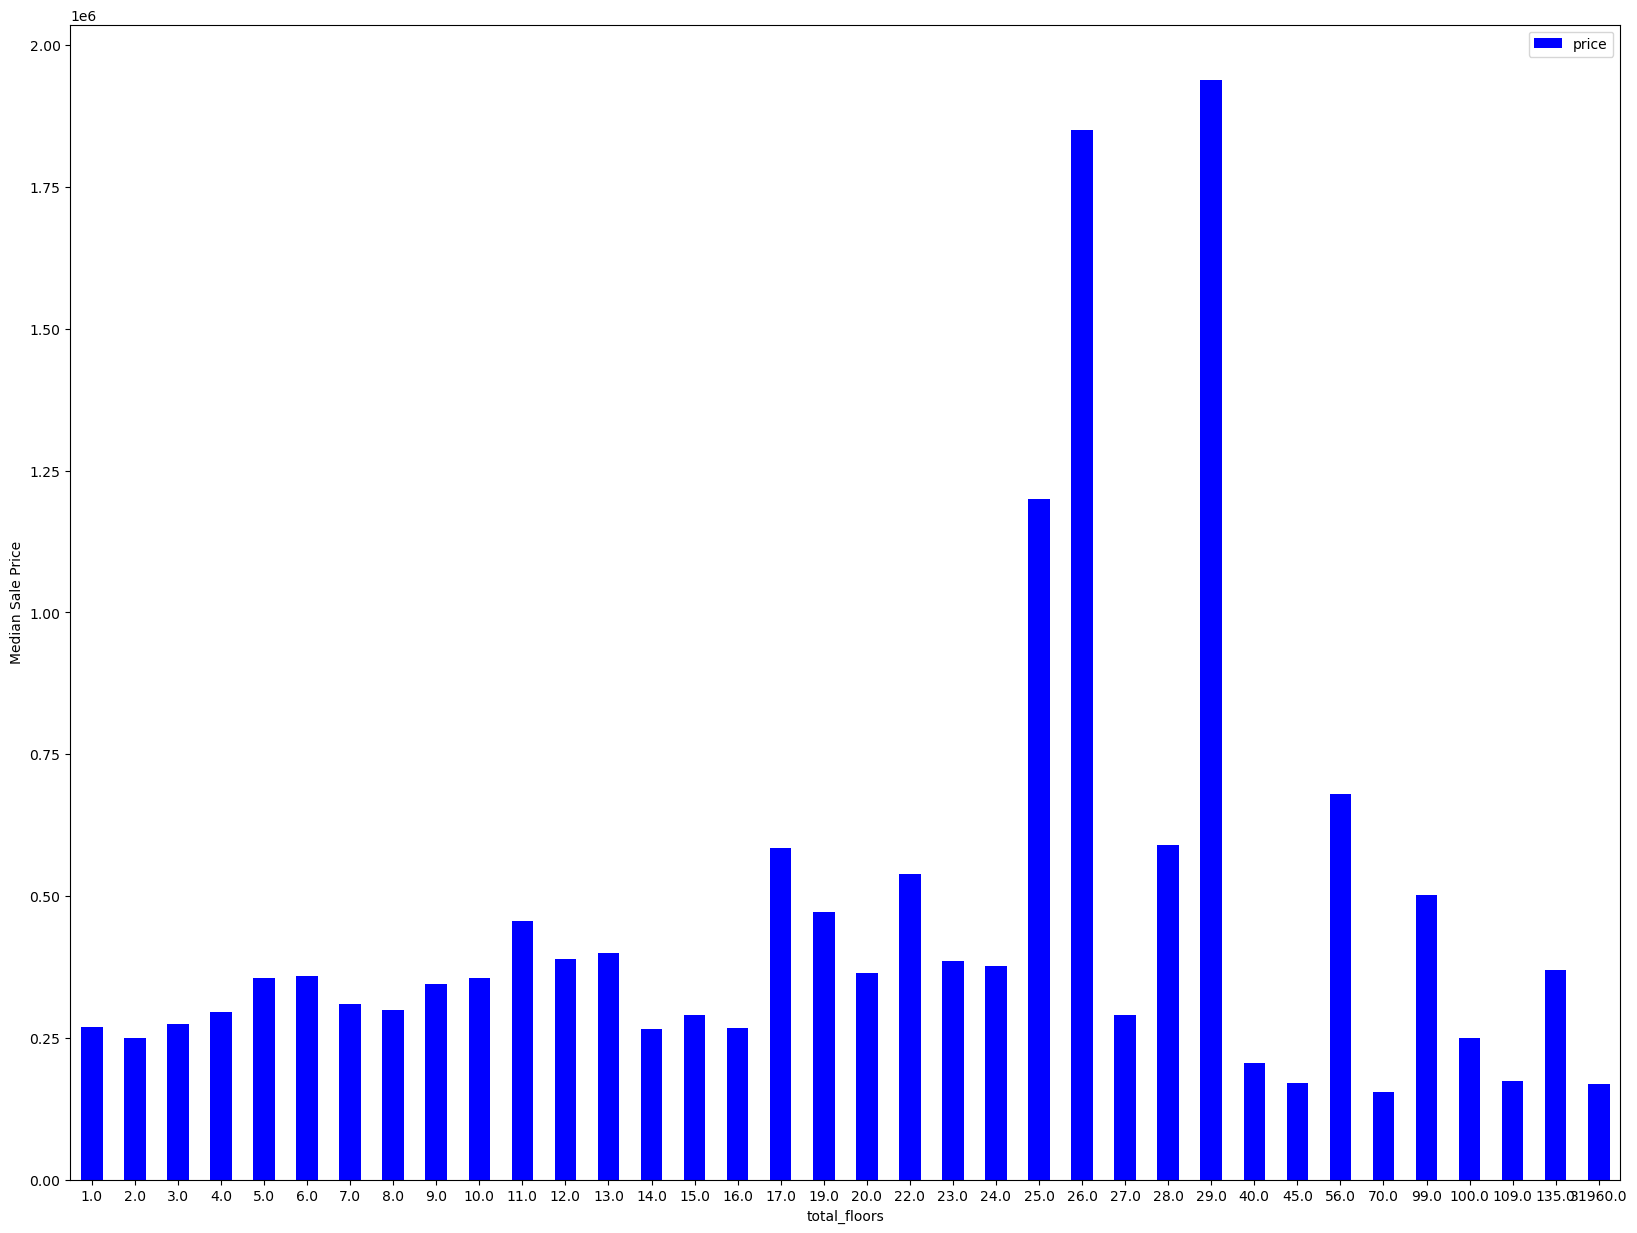

In [129]:
#Transform variable total_floors by encoding it as a new categorical feature

total_floors_pivot = df_train.pivot_table(index='total_floors', values='price', aggfunc=np.median)
total_floors_pivot.plot(kind='bar', color='blue',figsize=(20,15))
plt.xlabel('total_floors')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

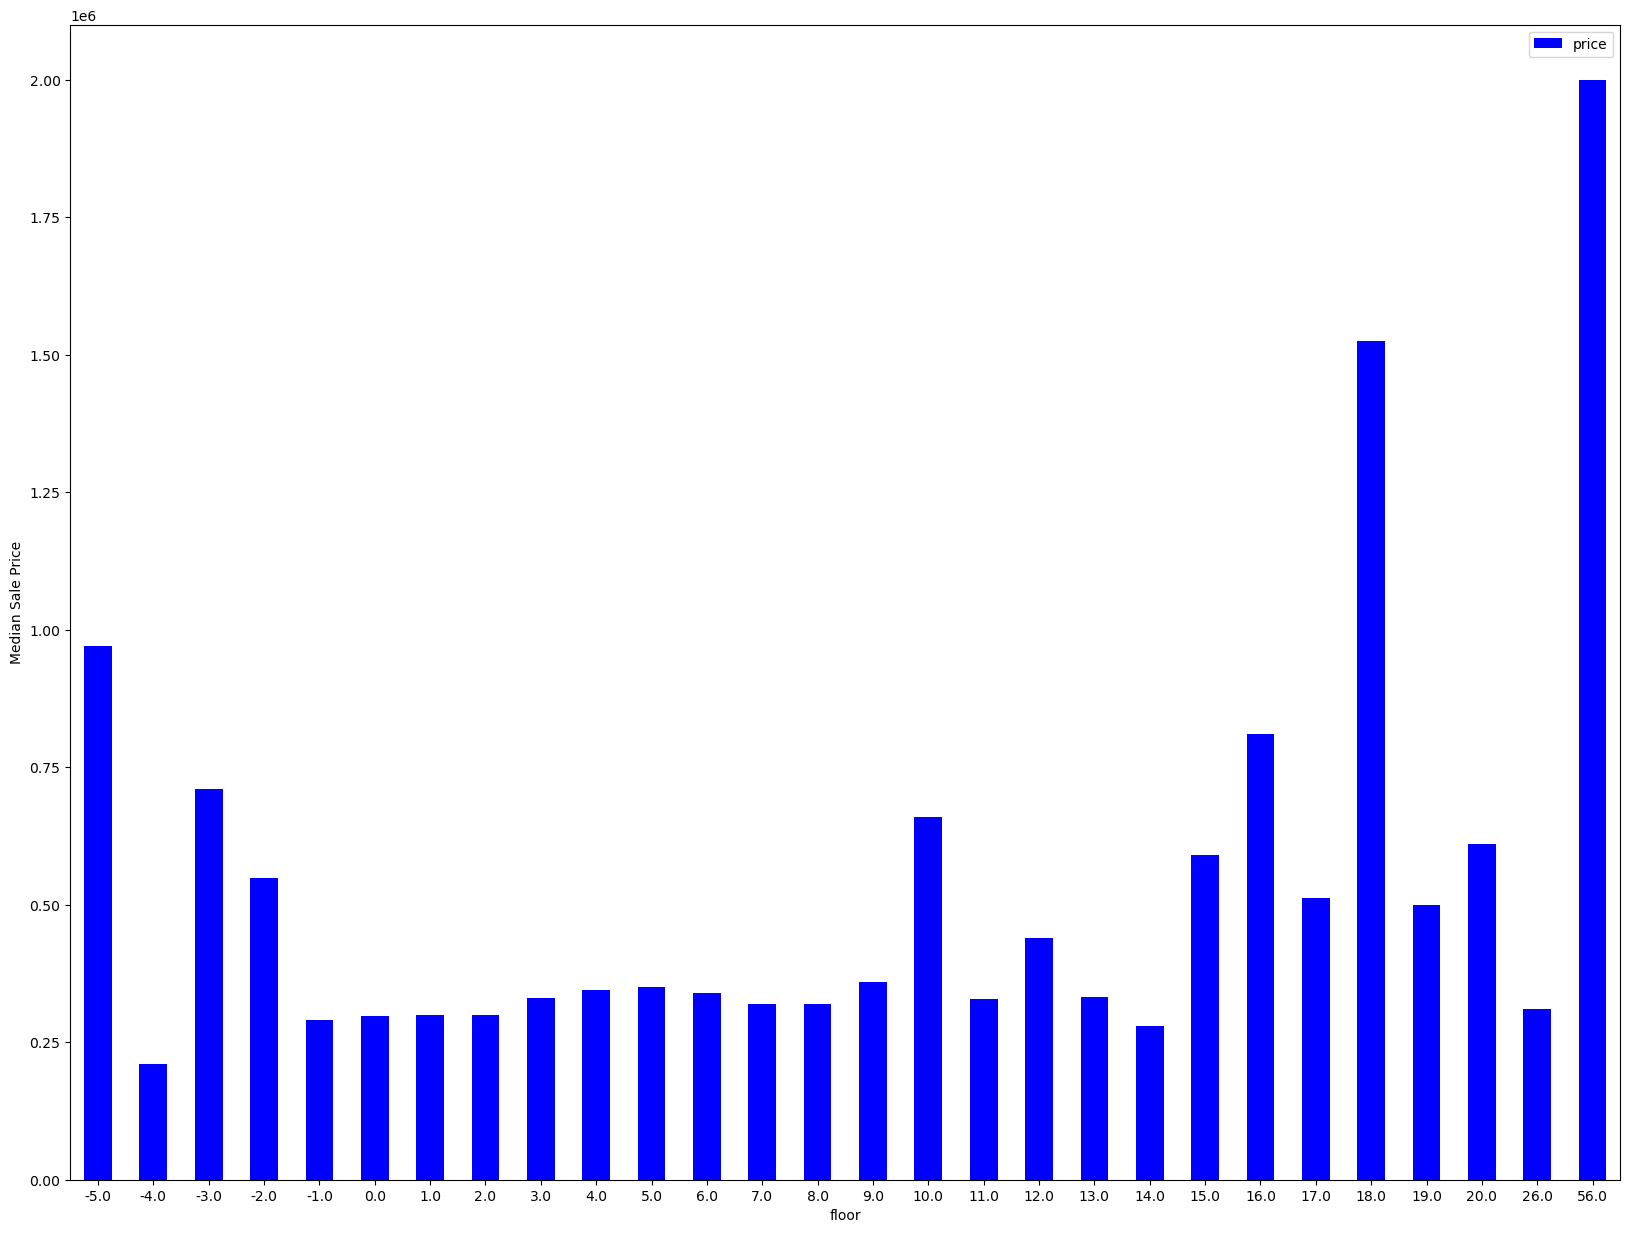

In [130]:
#Transform variable floor by encoding it as a new categorical feature


floor_pivot = df_train.pivot_table(index='floor', values='price', aggfunc=np.median)
floor_pivot.plot(kind='bar', color='blue',figsize=(20,15))
plt.xlabel('floor')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()


## **WORKING ON DF_TRAIN3, DF_ROME3 etc. only**

A ja uparcie na df_train_reduced :D

In [ ]:
# df_train3.drop(['latitude','longitude','city'], axis=1, inplace=True)

#  # One-hot encode the 'conditions' column
# df_train3 = pd.get_dummies(df_train2, columns=['condition'])
# df_train3.drop(['latitude','longitude'], axis=1, inplace=True)

# df_train3.info()

In [131]:
# One-hot encode the 'city' column
df_train_reduced_with_cities = pd.get_dummies(df_train_reduced, columns=['city'])
df_train_reduced_with_cities.columns

Index(['balcony', 'conditions', 'latitude', 'longitude', 'floor', 'garden',
       'n_bathrooms', 'elevator', 'n_rooms', 'proximity_to_center', 'surface',
       'price_log10', 'only_stairs', 'conditions_Buono stato / Abitabile',
       'conditions_Da ristrutturare', 'conditions_Nuovo / Nuova costruzione',
       'conditions_Ottimo / Ristrutturato', 'enc_proximity', 'city_Milan',
       'city_Rome', 'city_Venice'],
      dtype='object')

In [133]:
df_train_final = df_train_reduced_with_cities[['balcony', 'garden', 'n_bathrooms',  'n_rooms', 'surface', 
                                  'price_log10', 'only_stairs', 'conditions_Buono stato / Abitabile',
                                  'conditions_Da ristrutturare', 'conditions_Nuovo / Nuova costruzione',
                                  'conditions_Ottimo / Ristrutturato', 'enc_proximity', 'city_Milan',
                                    'city_Rome', 'city_Venice']].copy()



In [134]:
df_train_final.head()

,balcony,garden,n_bathrooms,n_rooms,surface,price_log10,only_stairs,conditions_Buono stato / Abitabile,conditions_Da ristrutturare,conditions_Nuovo / Nuova costruzione,conditions_Ottimo / Ristrutturato,enc_proximity,city_Milan,city_Rome,city_Venice
id,,,,,,,,,,,,,,,
10461,1,0,1.0,1.0,35.0,4.778151,1,1,0,0,0,1,0,1,0
51304,0,0,1.0,3.0,131.0,5.954243,0,1,0,0,0,1,0,1,0
33032,0,0,1.0,1.0,16.0,4.518514,1,1,0,0,0,1,0,1,0
62281,0,1,1.0,2.0,100.0,5.220108,0,0,0,0,1,0,0,0,1
45681,1,0,2.0,3.0,90.0,5.612784,0,1,0,0,0,1,0,0,1


## MODEL

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

** KONIECZNIE SCALING DODAC **

to bedzie cos w stylu

"""
from sklearn.jakas_biblioteka import StandardScaler()

scaler = StandardScaler()
scaler.fit_transform(X)
"""

In [137]:
# Zostawiamy same 'values'. Do modelu feedujemy same wartosci.
X = df_train_final.drop(['price_log10'], axis = 1).values
Y = df_train_final['price_log10'].values

# Split the training set into
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [138]:
#SVR
model_SVR = SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)
 
print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.029208163105368307


Bardzo maly error, moze byc overfitting. Wybralbym jeden z trzech, potem zrobil maly gridsearchCV na hiperparametrach(np. zmieniajac liczbe n_estimators w RFR)

In [139]:
#RANDOM FOREST 
# from sklearn.ensemble import RandomForestRegressor --- nie trzeba importowac, juz jest pare komorek wyzej
 
model_RFR = RandomForestRegressor(n_estimators=100)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)
 
mean_absolute_percentage_error(Y_valid, Y_pred)

0.02753796842894809

In [140]:
#POLYNOMIAL REGRESSION
 
model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)
 
print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.030419586884306102
